## IDS/ACM/CS 158: Fundamentals of Statistical Learning
### PS4, Problem 1: The LASSO
> Name: Li, Michael
 
> Email address: mlli@caltech.edu

Notes:
Please use python 3.6

You are required to properly comment and organize your code.

* Helper functions (add/remove part label according to the specific question requirements)

In [1]:
import numpy as np
import numpy.matlib
import scipy.stats
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')

def predict(ols, data, y_avg):
    """
    ols - ols estimate of the regression parameter
    data - a matrix where each row corresponds to the 
           p predictors in the first p columns and
           the observed output y in the final column
    y_avg - average y prediction from the training data
            to add back when we predict
           
    returns the predictions for the observations in data
    """
    return np.matmul(data[:,:-1], ols) + y_avg

def l2_loss(data, preds):
    """
    data - a matrix where each row corresponds to the 
           p predictors in the first p columns and
           the observed output y in the final column
    preds - the predictions for the observations in data
    
    returns the L2 loss of the values
    """
    return np.mean((data[:,-1] - preds)**2)

def split_folds(folds, index):
    """
    folds - list of K folds of data
    index - which of the folds to use for test data
    
    returns train and test of the data
    """
    test = folds[index]
    train_temp = np.delete(folds, index, axis=0)
    train = []
    
    for fold in train_temp:
        for row in fold:
            train.append(row)
    
    return np.array(train), test

def kfolds(data):
    """
    data - data to split into 5 folds
    
    returns 5 different folds of data
    """
    np.random.shuffle(data)
    return [data[:19], data[19:38], data[38:57], data[57:77], data[77:]]
    
def mean_and_se(data):
    """
    data - a column of data
    
    returns the mean of the data and standard error
    """
    mean = np.mean(data)
    se = np.sqrt(np.mean((data-mean)**2))
    
    return mean, se

In [2]:
class LassoPreprocessor:
    """
    Object that keeps track of the training preprocesing step
    
    Initialize with data and object keeps track of 
    mean of each column, standard deviations of each column, and 
    the average y of the data
    """
    def __init__(self, data):
        self.means = np.mean(data[:,:-1], axis=0)
        self.stds = np.std(data[:,:-1], axis=0, ddof=1)
        self.y_avg= np.mean(data[:,-1])
        
    def _standardize_col(self, column, mean, std):
        """
        column - an np array of values from a population

        returns the standardized column with mean 0 and std = 1
        """
        return (column - mean) / std  
    
    def preprocess(self, data):
        """
        given a dataset, standardize it using the saved means, stds, and y_avg
        """
        standardized_data = data.copy()
        
        for i in range(len(data[0])-1):
            standardized_data[:,i] = self._standardize_col(data[:,i], self.means[i], self.stds[i])
            
        standardized_data[:,-1] -= self.y_avg
        
        return standardized_data
    
    def get_y_avg(self):
        """
        Getter method to get the y_avg value
        """
        return self.y_avg

In [3]:
data = np.genfromtxt('prostate_cancer.csv', delimiter=',', skip_header=1)[:,:-1]

In [4]:
cvs = defaultdict(list)

for _ in range(100):
    # split up our data into folds
    folds = kfolds(data)
    
    for lamb in np.linspace(0, 1, 101, endpoint=True):
        cv_err = []
        
        for k in range(len(folds)):
            # organize our train and test and preprocess everything according to train
            train, test = split_folds(folds, k)
            preprocessor = LassoPreprocessor(train)
            train_processed = preprocessor.preprocess(train)
            test_processed = preprocessor.preprocess(test)
            
            # calculate lasso estimates and calculate error for fold
            clf = Lasso(alpha=lamb, fit_intercept=False, normalize=False, max_iter=10000)
            clf.fit(train_processed[:,:-1], train_processed[:,-1])
            test_preds = predict(clf.coef_, test_processed, preprocessor.get_y_avg())
            cv_err.append(l2_loss(test, test_preds))
            
        # keep track of average cross validation error for 5 folds
        cvs[lamb].append(np.mean(cv_err))

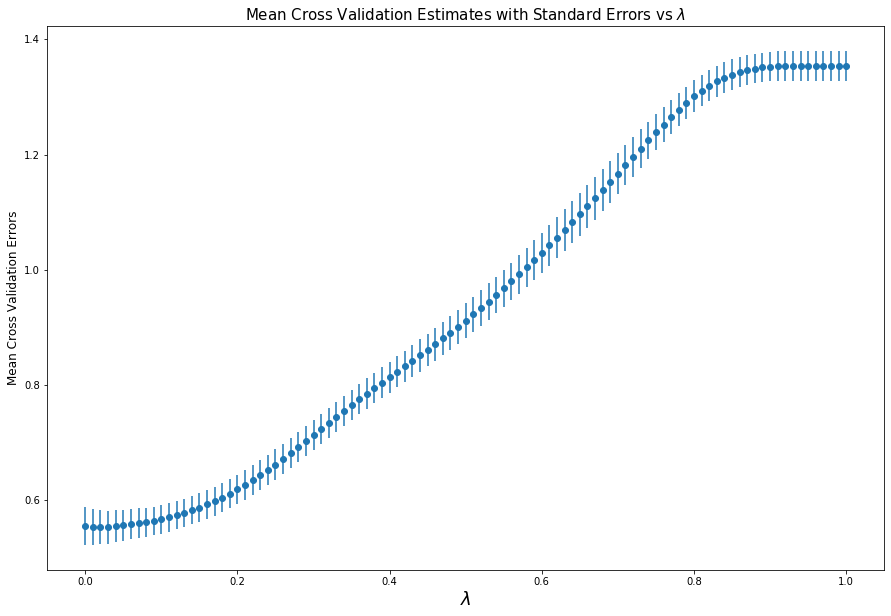

In [5]:
means = []
ses = []

for key in cvs:
    mean, se = mean_and_se(cvs[key])
    means.append(mean)
    ses.append(se)

plt.rcParams['figure.figsize'] = [15, 10]
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('Mean Cross Validation Errors', fontsize=12)
plt.title('Mean Cross Validation Estimates with Standard Errors vs $\lambda$', fontsize=15)
plt.errorbar(np.linspace(0, 1, 101, endpoint=True), means, ses, linestyle='None', marker='o')
plt.show()

In [6]:
lamb_min_index = np.argmin(means)
lamb_min = lamb_min_index * .01
lamb_min

0.03

In [7]:
lamb_best = None

for i in range(len(means)-1, -1, -1):
    if means[i] < means[lamb_min_index] + ses[lamb_min_index]:
        lamb_best_index = i
        lamb_best = i * .01
        break
        
lamb_best

0.13

In [8]:
data = np.genfromtxt('prostate_cancer.csv', delimiter=',', skip_header=1)[:,:-1]
preprocessor = LassoPreprocessor(data)
data = preprocessor.preprocess(data)

In [9]:
betas = []

for lamb in np.linspace(0, 1, 101, endpoint=True):
    clf = Lasso(alpha=lamb, fit_intercept=False, normalize=False, max_iter=10000)
    clf.fit(data[:,:-1], data[:,-1])
    betas.append(clf.coef_)


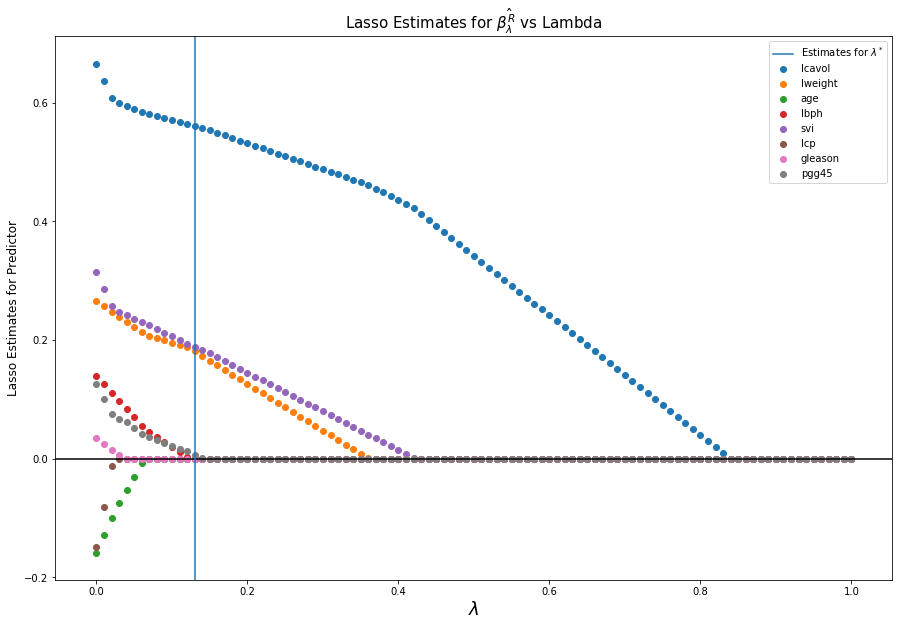

In [12]:
labels = ["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45"]
plt.rcParams['figure.figsize'] = [15, 10]
for i in range(len(labels)):
    plt.scatter(np.linspace(0, 1, 101, endpoint=True), np.array(betas)[:,i], label=labels[i])

plt.axhline(y=0, color='k')
plt.axvline(lamb_best, label='Estimates for $\lambda^*$')
plt.legend()
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('Lasso Estimates for Predictor', fontsize=12)
plt.title(r'Lasso Estimates for $\hat{\beta_\lambda^R}$ vs Lambda', fontsize=15)
plt.show()

In [11]:
betas[lamb_best_index], preprocessor.get_y_avg()

(array([ 0.56082709,  0.18144093, -0.        ,  0.        ,  0.18858446,
         0.        ,  0.        ,  0.00714978]),
 2.478386878350515)

The best final model is $f(X) = \bar{y} + \sum_{i=1}^p \hat{\beta_{i, \lambda^*}^R}X_i$ where $\hat{\beta_{i, \lambda^*}^R}$ = [ 0.56082709,  0.18144093, 0.        ,  0.        ,  0.18858446, 0.        ,  0.        ,  0.00714978] and $\bar{y}$ = 2.478